In [20]:
# 导入必要的库
# !pip install --upgrade matplotlib
# !pip instgall --upgrade timeseries_generator

import pandas as pd
import numpy as np
from timeseries_generator import Generator
from timeseries_generator import LinearTrend,  WhiteNoise, WeekdayFactor, HolidayFactor, RandomFeatureFactor

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#(1) Use a synthetic time series generator (e.g. https://github.com/NikeInc/timeseries-generator or) and generate time series that has some patterns. 

In [25]:

# 定义不同的时间序列因子
linear_trend = LinearTrend(coef=20.1, offset=0.3)
white_noise = WhiteNoise(stdev_factor=0.1)
weekday_effect = WeekdayFactor()
# 创建时间序列生成器

# 创建时间序列生成器
date_range = pd.date_range('2021-01-01', '2021-12-31')
generator = Generator(factors=[linear_trend, white_noise, weekday_effect], date_range= date_range)



# 生成数据
df = generator.generate()


# Assuming 'value' is the column you want to predict
data = df['value'].values.reshape(-1, 1)



<Axes: >

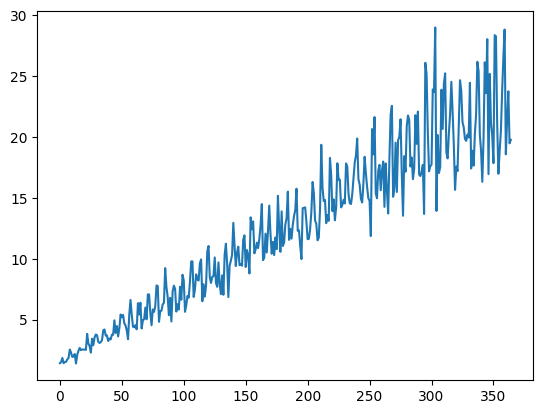

In [26]:

 df['value'].plot()

In [27]:
import torch
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch.nn as nn

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)

# Convert to PyTorch tensors
data_normalized = torch.FloatTensor(data_normalized).view(-1)


In [28]:

# Create sequences and corresponding labels
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_window = 12  # example window size
sequences = create_inout_sequences(data_normalized, train_window)


In [28]:
# (2) Experiment prediction on the time series with LSTM, GRU, BiDirectional RNN and Deep RNN. 


In [29]:
# Define an LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    
    
    

# Define a GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Define Bidirectional RNN
class BiRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BiRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)  # Multiply by 2 for bidirectional

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_()  # Multiply by 2 for bidirectional
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])  # Concatenate the last output of both directions
        return out



# Define Deep RNN
class DeepRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(DeepRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out



In [30]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        sequence = sequence.clone().detach().view(1, 12).float()
        label = label.clone().detach().float()
        return sequence, label 
        
        # return torch.tensor(sequence, dtype=torch.float).view(1, 12)  , torch.tensor(label, dtype=torch.float)
    
    
train_sequences = sequences[:-30]  # 保留除最后30条之外的所有数据作为训练集
test_sequences = sequences[-30:]   # 最后30条数据作为测试集

# 创建训练和测试数据集
train_dataset = TimeSeriesDataset(train_sequences)
test_dataset = TimeSeriesDataset(test_sequences)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 您可以根据需要调整 batch_size 和 shuffle
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [31]:
import time

def eval_one_model(name, model, learning_rate = 0.02, num_epochs=100):
    criterion = nn.MSELoss()  # or nn.CrossEntropyLoss() for classification
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    #5. Training Loop   
    start = time.time()
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:  # Assuming DataLoader is used
            # print(inputs.shape)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # print(f"Epoch {epoch+1}/{num_epochs} for {name} completed")
    print("Time consumed:", time.time() - start)
        
     # 评估循环
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
        avg_loss = total_loss / len(test_loader)
        print(f'Average Loss of {name} on test data: {avg_loss}')


In [32]:
input_dim = 12
hidden_dim = 128
layer_dim = 3
output_dim = 1

eval_one_model("LSTM", LSTMModel(input_dim, hidden_dim, layer_dim, output_dim))

Time consumed: 13.17988920211792
Average Loss of LSTM on test data: 0.06246057339012623


In [33]:
eval_one_model("GRU", GRUModel(input_dim, hidden_dim, layer_dim, output_dim))

Time consumed: 9.58746862411499
Average Loss of GRU on test data: 0.09007959440350533


In [34]:
eval_one_model("BiRNN", BiRNNModel(input_dim, hidden_dim, layer_dim, output_dim))

Time consumed: 11.776988983154297
Average Loss of BiRNN on test data: 0.18911629170179367


In [35]:
eval_one_model("DeepRNN", DeepRNNModel(input_dim, hidden_dim, layer_dim, output_dim))

Time consumed: 5.6071860790252686
Average Loss of DeepRNN on test data: 0.11218990013003349


In [36]:
#(3) Increase the size of the time series three times, and perform the experiments in 
step 2, again three times

In [37]:


date_range = pd.date_range('2021-01-01', '2023-12-31')
# 创建时间序列生成器
generator = Generator(factors=[linear_trend, white_noise, weekday_effect],
                      date_range=date_range)

# 生成数据
df = generator.generate()


# Assuming 'value' is the column you want to predict
data = df['value'].values.reshape(-1, 1)


data_normalized = scaler.fit_transform(data)

# Convert to PyTorch tensors
data_normalized = torch.FloatTensor(data_normalized).view(-1)



train_window = 12  # example window size
sequences = create_inout_sequences(data_normalized, train_window)



train_sequences = sequences[:-30]  # 保留除最后30条之外的所有数据作为训练集
test_sequences = sequences[-30:]   # 最后30条数据作为测试集

# 创建训练和测试数据集
train_dataset = TimeSeriesDataset(train_sequences)
test_dataset = TimeSeriesDataset(test_sequences)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 您可以根据需要调整 batch_size 和 shuffle
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [38]:
eval_one_model("LSTM", LSTMModel(input_dim, hidden_dim, layer_dim, output_dim))

Time consumed: 47.65004348754883
Average Loss of LSTM on test data: 0.03841605503112078


In [39]:
eval_one_model("GRU", GRUModel(input_dim, hidden_dim, layer_dim, output_dim))

Time consumed: 33.44635510444641
Average Loss of GRU on test data: 0.04132590629160404


In [40]:
eval_one_model("BiRNN", BiRNNModel(input_dim, hidden_dim, layer_dim, output_dim))

Time consumed: 41.9881227016449
Average Loss of BiRNN on test data: 1.0283360481262207


In [41]:
eval_one_model("DeepRNN", DeepRNNModel(input_dim, hidden_dim, layer_dim, output_dim))

Time consumed: 19.610931396484375
Average Loss of DeepRNN on test data: 0.5989908874034882
